In [239]:
import os
import time

import cv2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from scipy import ndimage as nd
from skimage import transform
from tqdm.notebook import tqdm

#import isx

In [2]:
def apply_butterworth(sig,cutoff,fs,filt_order,filt_type):
    #
    # applies zero-phase digital butterworth filter to data in sig
    # if sig is a matrix, data in its columns are filtered
    #
    # cutoff is filter's critical frequency in Hz, or n=2 tuple of freqs for bandpass filters
    # fs is sampling rate
    # filt_order is integer filter order
    # filt_type is 'lowpass','highpass', 'bandpass', or 'bandstop' 
    # 
    # returns filtered signal 
    #
    
    nyq = 0.5 * fs
    norm_cutoff =cutoff/nyq
    b,a = signal.butter(filt_order,norm_cutoff,btype=filt_type,analog=False)
    
    if sig.ndim > 1:
        filt_sig = signal.filtfilt(b,a,sig,axis=1)
    elif sig.ndim == 1:
        filt_sig = signal.filtfilt(b,a,sig)
    else:
        filt_sig = []
    
    return filt_sig

def median_filter_matrix(inmtx,winsize=3):
    #
    # median filters each column of matrix with kernal width = winsize
    #
    # returns filtered matrix
    #
    
    filtmtx = np.zeros_like(inmtx)
    
    for i in range(inmtx.shape[0]):
        filtmtx[i] = signal.medfilt(inmtx[i],winsize)
    return filtmtx

def otsu(x):
    # returns threshold estimated via Otsu's method
    # x needs to be 1-d list
    nbins = 500
    logx = np.log(x)
    
    minim = min(logx)
    maxim = max(logx)
    logx = (logx-minim)/(maxim-minim)
    
    xhist = np.histogram(logx,bins=nbins)
    xbins = xhist[1]
    xbins = xbins[1:]
    xcounts = xhist[0] / sum(xhist[0])

    maximum = 0
    thresh = 0
    
    for t in range(len(xcounts)):
        w0 = sum(xcounts[:t])
        w1 = sum(xcounts) - w0
        if w0 == 0 or w1 == 0:
            #print('continuing...')
            continue
        mu0 = sum(xbins[:t]*xcounts[:t]) / w0
        mu1 = sum(xbins[t:]*xcounts[t:]) / w1
        sigB = w0 * w1 * ((mu0 - mu1) * (mu0 - mu1))
        if sigB >= maximum:
            maximum = sigB
            thresh = xbins[t]
    
    th = thresh*(maxim-minim) + minim
    th = np.exp(th)
    #th = np.power(10,th)
    thresh = th

    return thresh


def register_signals(ref_time,in_dat,in_time):
    #
    # Direct alignment of signals that were sampled at diffrent rates
    # resamples in_dat to len(ref_time) by aligning timestamps in ref_time with timestamps in in_time
    # in_time is vector of timestamps for data in in_dat
    #
    # len(ref_time) < len(in_time)
    #
    #
    
    resamp_dat = np.zeros_like(ref_time)

    for t in range(len(ref_time)):
        dat = in_dat[bisect.bisect(in_time,ref_time[t])-1]
        resamp_dat[t] = dat
    return resamp_dat
    
def segment(x,thresh):
    # returns onsets & offset indices of impulses that exceed thresh in vector x
    xsub = x - thresh
    xdiff = (xsub[:-1]*xsub[1:]) < 0
    edges = np.where(xdiff == 1) # indices at onsets/offsets
    edges = list(edges[0])
    
    x[0:5] = 0
    
    if np.mean(np.diff(x[edges[0]-2:edges[0]+2])) < 0: # delete first impulse if offset
        print('first impulse is offset')
        edges.pop(0)
    if np.mean(np.diff(x[edges[-1]-2:edges[-1]+2])) > 0: # delete last impulse if onset
        print('last impulse is onset')
        edges.pop(-1)
    onsets = edges[0::2]
    offsets = edges[1::2]
    
    if len(onsets) > len(offsets):
        onsets.pop(-1)
    
    return [onsets,offsets]

def extractsegments(x,onsets,offsets,win):
    # returns list of slices from x[onsets[i]-win:offsets[i]+win]
    
    win = int(win)
    if onsets[0] - win < 1 or offsets[-1] > len(x):
        print('Edge Syllable')
        return []
    else:
        segs = [x[onsets[i]-win : offsets[i]+win] for i in range(len(onsets))]
        return segs
    
def filtersegments(segs,minlen,maxlen):
    # deletes elements of segs with maxlen < len() < minlen
    return [i for i in segs if len(i) > minlen and len(i) < maxlen]
    
def twoaxis(axname,lwidth=2):
    #
    # formats axes by setting axis thickness & ticks to lwidth and clearing top/right axes
    #
    #
    axname.spines['bottom'].set_linewidth(lwidth)
    axname.tick_params(width=lwidth)
    axname.spines['left'].set_linewidth(lwidth)
    axname.spines['top'].set_linewidth(0)
    axname.spines['right'].set_linewidth(0)
    
# functions for object detection:

def subtract_img_background(input_img):
    #
    # Uses pixel dilation to adaptively filter nonuniform background from objects in input_img
    #
    # input image is NxM  matrix of pixel intensities 
    #
    # returns filtered image.
    #
    # Adapted from skimage 'Filtering regional maxima'. Requires : 
    # import numpy as np
    # import matplotlib.pyplot as plt
    # from scipy.ndimage import gaussian_filter
    # from skimage.filters import threshold_otsu
    # #from skimage import img_as_float
    # from skimage.morphology import reconstruction
    #
    #
    img = img_as_float(input_img)
    img_g = gaussian_filter(img,1)

    h = threshold_otsu(img_g)

    seed = img_g - h
    mask = img_g

    dilated = reconstruction(seed,mask,method='dilation')

    return img_g-dilated

def norm_image(in_img):
    #
    # returns in_img normalized to [0-255]
    #
    #
    
    i_min = np.min(in_img)
    i_max = np.max(in_img)
    
    norm_img = 255 * ((in_img + abs(i_min) / i_max))
    
    return norm_img

def estimate_num_cells(in_img):
    #
    # Estimates number of gaussian-like blobs in in_img using laplacian of gaussians (LoG)
    #
    # 
    # in_img is NxM matrix of pixel intensities
    # in_img is probably maximum or other projection of motion corrected or df/f movie
    #
    # requires skimage.feature.blob_log()
    #
    # returns N x 3 matrix, N=num_blobs, out[0] = y coordinates, out[1] = x coordinates, out[2] = blob radius 
    #
    
    # log_params:
    min_sigma = 2
    max_sigma = 20
    num_sigma = int((max_sigma-min_sigma))
    threshold = 1
    overlap =0.1
    
    img_background_subtract = subtract_img_background(in_img)
    img_norm = norm_image(img_background_subtract)
    objs = blob_log(img_norm,min_sigma = min_sigma,max_sigma=max_sigma,num_sigma=num_sigma,threshold=threshold,overlap=overlap)
    
    return objs


In [3]:
def get_background_images(in_movie, seg_times, n_background_frames = 500, fps = 20):
    #
    # 
    #
    #
    #
    
    print('Background detection assuming {}fps video\n'.format(fps))
    
    rng = np.random.default_rng()
    
    vid = cv2.VideoCapture(in_movie)
    num_frames = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    vid_size = [int(vid.get(4)), int(vid.get(3))]
    
    # convert segments to indices and add start/stop frames:
    seg_times = [int(i*fps) for i in seg_times]
    seg_times.append(num_frames)
    seg_times.insert(0, 0)
    seg_idx = [[i, j] for i,j in zip(seg_times[:-1], seg_times[1:]) ]
    
    out_list = []
    
    # build background image for each segment:
    for seg in tqdm(seg_idx):
        framevect = np.unique(rng.integers(seg[0], seg[1], int(n_background_frames * 2)))[:n_background_frames] # draw n_background_frames without replacement
        background_dat = np.zeros( (len(framevect), vid_size[0], vid_size[1]) ).astype('uint8')
        #vid = cv2.VideoCapture(vid_fn)
        #bidx = 0
        for bidx,i in enumerate(framevect):
            vid.set(1, i)
            theframe = vid.read()[1]
            grayscale = cv2.cvtColor(theframe,cv2.COLOR_BGR2GRAY).astype('uint8')
            #grayscale = (np.sum(theframe,axis=2)/3).astype('uint8')
            background_dat[bidx] = grayscale
            #bidx += 1        

        #background_frame = np.median(background_dat, axis=0)
        out_list.append(np.median(background_dat, axis=0))
        

    
    vid.release()
    return out_list

###################################################################################
###################################################################################

def movie_com(in_movie, background_movie, seg_times, filt_size = 10, ds_fact = 4, pthresh = 99, fps = 20):
    #
    #
    #

    vid = cv2.VideoCapture(in_movie)
    num_frames = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_range = list(range(num_frames))

    # initialize output:
    com_vect = np.zeros((len(frame_range),2)).astype('int32')
    
    seg_times = [int(i*fps) for i in seg_times]
    seg_times.append(num_frames)
    seg_times.insert(0, 0)
    seg_idx = [[i, j] for i,j in zip(seg_times[:-1], seg_times[1:]) ]
    
    movie_epochs = [np.arange(i[0],i[1]) for i in seg_idx]
    print(np.shape(movie_epochs))

    for framei in tqdm(range(len(frame_range))):
        vid.set(1, framei)
        theframe = vid.read()[1]

        background_frame_ds = transform.downscale_local_mean(background_movie[np.argwhere([framei in i for i in movie_epochs])[0][0]], (ds_fact, ds_fact))
        grayscale = transform.downscale_local_mean( cv2.cvtColor(theframe,cv2.COLOR_BGR2GRAY).astype('uint8'), (ds_fact,ds_fact))

        bg_subtracted = grayscale - background_frame_ds
        bg_subtracted[bg_subtracted > np.percentile(bg_subtracted, 100-pthresh)] = 0
        bg_subtracted[bg_subtracted > 0] = 255

        center_of_mass = nd.center_of_mass(nd.maximum_filter(bg_subtracted, int(filt_size / ds_fact )))
        
        if sum(np.isnan(center_of_mass)):
            com_vect[framei] = com_vect[framei -1]
        else:
            com_vect[framei] = [i for i in center_of_mass]

    vid.release()
    return com_vect

###################################################################################
###################################################################################


    


In [11]:
def fix_data_path(the_path, base_path = 'ariel', path_sep = '\\'):
    '''
    fix_data_path(thepath, basepath = '/ariel/'):
    
    INPUTS:
    the_path <str>:
    base_path <str>:
    
    OUTPUTS:
    out_path <str>:
    
    '''
    
    path_elements = the_path.split(path_sep)
    for idx,i in enumerate(path_elements):  
        if i=='science-1':
            path_elements[idx] = 'science'
        if i=='data':
            path_elements[idx] = ''
    path_elements = [base_path] + [i for i in path_elements if len(i)]
    path_elements = ['/']+[i+'/' for i in path_elements]

    return ''.join(path_elements)
    

    

## Gather data from spreadsheet

In [4]:
log_fn = '/home/mmiller/Downloads/Experimental Log - Sheet1.csv'
log_df = pd.read_csv(log_fn)
log_df.head()

,date,subject_ID,genotype,virus,expression_time,brain_region,condition,data_dir_ca,isxd_data_basename,data_dir_behavior,behav_data_basename,Focus,Gain,LED,Comments,num_cells
0,20200302,OM025,PV,CaM6m_FLEXeNpHR,8 weeks,mPFC,enphr_stim,\\science-1\data\OM\Astellas\inscopix_imaging\...,2020-03-02-12-04-44_video,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20200302,OM025,PV,CaM6m_FLEXeNpHR,8 weeks,mPFC,enphr_stim,\\science-1\data\OM\Astellas\inscopix_imaging\...,2020-03-02-12-26-53_video,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20200302,OM025,PV,CaM6m_FLEXeNpHR,8 weeks,mPFC,linear_social,\\science-1\data\OM\Astellas\inscopix_imaging\...,2020-03-02-14-25-34_video,NaN,Behavior_2020-03-02-14-25-34_video,NaN,NaN,NaN,NaN,NaN
3,20200401,OM037,FMR1CTRL,CaM6m,5 weeks,mPFC,linear_social,\\science-1\data\OM\Astellas\inscopix_imaging\...,2020-04-01-14-34-36_video,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-01-14-34-36_video,660.0,6.8,0.2,num cells estimate is low due to blurry projec...,29.0
4,20200401,OM047,FMR1CTRL,CaM6m,5 weeks,mPFC,linear_social,\\science-1\data\OM\Astellas\inscopix_imaging\...,2020-04-01-15-19-03_video,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-01-15-19-03_video,610.0,6.4,0.4,lens insertion only 5 days ago,74.0


In [5]:
behavior_dir = '/home/mmiller/Documents/data/astellas/fmr1ko_linear_social/April2020_FMR1_LinearSocial/'
com_list = [i for i in os.listdir(behavior_dir) if os.path.splitext(i)[1] == '.csv']
#print(com_list)


In [6]:
print(com_list)

['behavior_2020-04-01-14-34-36_video_COM.csv', 'behavior_2020-04-02-11-16-06_video_COM.csv', 'behavior_2020-04-01-16-41-16_video_COM.csv', 'behavior_2020-04-01-15-19-03_video_COM.csv', 'behavior_2020-04-02-10-32-52_video_COM.csv', 'behavior_2020-04-02-09-54-15_video_COM.csv', 'behavior_2020-04-01-15-59-43_video_COM.csv', 'behavior_2020-04-02-11-57-37_video_COM.csv', 'behavior_2020-04-08-11-37-35_video_COM.csv', 'behavior_2020-04-08-12-15-55_video_COM.csv', 'behavior_2020-04-08-13-22-44_video_COM.csv', 'behavior_2020-04-08-14-02-40_video_COM.csv', 'behavior_2020-04-08-14-41-15_video_COM.csv', 'behavior_2020-04-08-15-21-57_video_COM.csv', 'behavior_2020-04-08-16-29-32_video_COM.csv', 'behavior_2020-04-15-14-03-28_video_COM.csv']


In [7]:
print(log_df.subject_ID.values)

['OM025' 'OM025' 'OM025' 'OM037' 'OM047' 'OM045' 'OM038' 'OM035' 'OM040'
 'OM042' 'OM051' 'OM037' 'OM047' 'OM045' 'OM038' 'OM051' 'OM042' 'OM040'
 'OM035' 'OM045' 'OM038' 'OM037' 'OM047' 'OM051' 'OM042' 'OM040' 'OM035'
 'OM045' 'OM045' 'OM038' 'OM038' 'OM047' 'OM047' 'OM035' 'OM035' 'OM051'
 'OM051' 'OM042' 'OM042' 'OM040' 'OM040' 'OM035' 'OM035']


In [145]:
vid_df = log_df[['subject_ID', 'genotype','data_dir_behavior' ,'behav_data_basename']].loc[(~log_df.behav_data_basename.isna()) & (log_df.expression_time=='6 weeks')].copy()

In [146]:
vid_df

,subject_ID,genotype,data_dir_behavior,behav_data_basename
12,OM047,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-11-37-35_video
13,OM045,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-12-15-55_video
14,OM038,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-13-22-44_video
15,OM051,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-14-02-40_video
16,OM042,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-14-41-15_video
17,OM040,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-15-21-57_video
18,OM035,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-16-29-32_video


In [147]:
subj_ids = vid_df.subject_ID.to_numpy()
print(vid_df.behav_data_basename.loc[vid_df.subject_ID==subj_ids[0]].values[0]+'_COM.mp4')
print(subj_ids)

behavior_2020-04-08-11-37-35_video_COM.mp4
['OM047' 'OM045' 'OM038' 'OM051' 'OM042' 'OM040' 'OM035']


In [223]:
# examine behavior zones on example video:
ds_fact = 1
x_threshs = [45 + 50  ,280 -50 ]
subj_id = 6
framei = int(60*20*7)


OM035


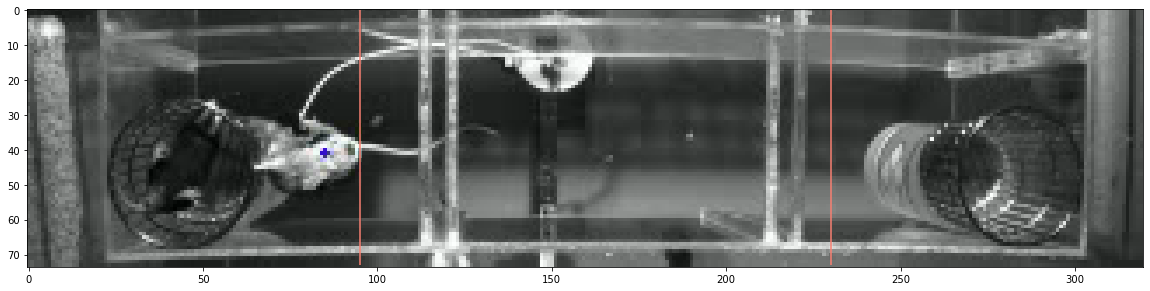

In [224]:
# examine behavior zones on example video:

#vid_fn = '/home/mmiller/Documents/data/astellas/fmr1ko_linear_social/April2020_FMR1_LinearSocial/behavior_2020-04-01-14-34-36_video_COM.mp4'
vid_fn = behavior_dir + vid_df.behav_data_basename.loc[vid_df.subject_ID==subj_ids[subj_id]].values[0]+'_COM.mp4'
print(subj_ids[subj_id])

vid = cv2.VideoCapture(vid_fn)
frame_height = vid.get(cv2.CAP_PROP_FRAME_HEIGHT)
vid.set(1, framei)
theframe = vid.read()[1]
#grayscale = transform.downscale_local_mean( cv2.cvtColor(theframe,cv2.COLOR_BGR2GRAY).astype('uint8'), (ds_fact,ds_fact)).astype('uint8')
vid.release()

f,ax = plt.subplots(1,1,figsize=(20,5))
ax.imshow(theframe,cmap='gray')
ax.vlines(x_threshs, ymin=0, ymax=frame_height-1, color='salmon')
plt.show()

### set test side for every video after examining sample frame:

In [168]:
#test_side=dict()
test_side[subj_ids[subj_id]] = 'l'
print(test_side)

{'OM047': 'l', 'OM045': 'r', 'OM038': 'l', 'OM051': 'r', 'OM042': 'l', 'OM040': 'r', 'OM035': 'l'}


In [173]:
subj_ids = vid_df.subject_ID.values
print(subj_ids)

['OM047' 'OM045' 'OM038' 'OM051' 'OM042' 'OM040' 'OM035']


In [174]:
vid_df['novel_side'] = vid_df['subject_ID'].map(test_side)

In [175]:
vid_df

,subject_ID,genotype,data_dir_behavior,behav_data_basename,novel_side
12,OM047,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-11-37-35_video,l
13,OM045,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-12-15-55_video,r
14,OM038,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-13-22-44_video,l
15,OM051,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-14-02-40_video,r
16,OM042,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-14-41-15_video,l
17,OM040,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-15-21-57_video,r
18,OM035,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-16-29-32_video,l


In [176]:
## count l/r occupancy for each epoch for each subject:
epoch_times = [0, int(5*60*20), int(15*60*20)]
buffer_len = 30*20

occupancy_dict = dict()


for subj in np.unique(subj_ids):
    print(subj)
    com_fn = behavior_dir + vid_df.behav_data_basename.loc[vid_df.subject_ID==subj].values[0]+'_COM.csv'
    #print(com_fn)
    the_com = np.loadtxt(com_fn, delimiter=',')
    
    the_epochs = list(np.copy(epoch_times))
    the_epochs.append(len(the_com))
    epoch_segs = [[i+buffer_len, j-buffer_len] for i,j in zip(the_epochs[0:-1], the_epochs[1:])]
    
    occupancy_times = []
    for seg_i, seg in enumerate(epoch_segs):
        print(seg)
        left_time = int(sum(the_com[seg[0]:seg[1], 1] < x_threshs[0]))
        right_time = int(sum(the_com[seg[0]:seg[1], 1] > x_threshs[1]))
        #out_times[subj_i, seg_i, :] = [left_time, right_time]
        
        if seg_i == 0:
            occupancy_times.append([left_time, right_time])
            print('Habituation scores',left_time,right_time)        
        
        if seg_i == 1: 
            if vid_df.novel_side.loc[vid_df.subject_ID == subj].values == 'l': # correctly order times to map social target position to the right ([object, pref])
                occupancy_times.append([right_time, left_time])
                print('remap scores:', right_time,left_time)
            else:
                occupancy_times.append([left_time, right_time])      
                print('unmapped scores',left_time,right_time)
        if seg_i == 2: 
            if vid_df.novel_side.loc[vid_df.subject_ID == subj].values == 'l': # correctly order times to map novel target position to the right ([pref, novel])
                occupancy_times.append([left_time, right_time])
                print('unmapped scores:', left_time,right_time)
            else:
                occupancy_times.append([right_time, left_time])      
                print('remapped scores',right_time, left_time)

    occupancy_dict[subj] = occupancy_times
    print('\n')
    
#print(occupancy_dict)

OM035
[600, 5400]
Habituation scores 417 2998
[6600, 17400]
remap scores: 4392 3043
[18600, 30543]
unmapped scores: 2460 4669


OM038
[600, 5400]
Habituation scores 2083 1153
[6600, 17400]
remap scores: 3623 4983
[18600, 29993]
unmapped scores: 3535 6412


OM040
[600, 5400]
Habituation scores 1025 2831
[6600, 17400]
unmapped scores 4310 4148
[18600, 30112]
remapped scores 4126 2352


OM042
[600, 5400]
Habituation scores 1122 2488
[6600, 17400]
remap scores: 4013 4697
[18600, 30186]
unmapped scores: 3094 6359


OM045
[600, 5400]
Habituation scores 1212 1422
[6600, 17400]
unmapped scores 3652 6099
[18600, 30435]
remapped scores 4865 4920


OM047
[600, 5400]
Habituation scores 574 2850
[6600, 17400]
remap scores: 5006 4312
[18600, 31003]
unmapped scores: 7179 4518


OM051
[600, 5400]
Habituation scores 1069 1438
[6600, 17400]
unmapped scores 6130 3506
[18600, 30257]
remapped scores 3577 3822




In [ ]:
vid_df

In [ ]:
occupancy_dict

In [ ]:
## populated df with occupancy scores
habituation_times = {i:j[0] for i,j in zip(occupancy_dict.keys(), occupancy_dict.values())}
print(habituation_times)


pref_times = {i:occupancy_dict[i][1] for i in occupancy_dict}
print(pref_times)

novel_times = {i:occupancy_dict[i][2] for i in occupancy_dict}
print(novel_times)

vid_df['habituation_counts'] = vid_df['subject_ID'].map(habituation_times)
vid_df['pref_counts'] = vid_df['subject_ID'].map(pref_times)
vid_df['novel_counts'] = vid_df['subject_ID'].map(novel_times)

In [ ]:
vid_df

In [ ]:
print(vid_df.genotype.unique())

In [ ]:
## plot / test occupancy:

conds = vid_df.genotype.unique()
cmap = plt.get_cmap('tab10')
cdict = dict(zip(conds, [cmap(i) for i in np.linspace(0, 1 , len(conds))]))

f,ax = plt.subplots(1, 2, figsize = (20,5), sharey=True)

for the_condition,a in zip(conds,ax):
    the_subjs = vid_df.subject_ID.loc[vid_df.genotype == the_condition]

    for i in vid_df.habituation_counts.loc[vid_df.subject_ID.isin(the_subjs)]:
        a.plot([1, 1.1], [j/20 for j in i], 'o-', color = cdict[the_condition])
    for i in vid_df.pref_counts.loc[vid_df.subject_ID.isin(the_subjs)]:
        a.plot([1.2, 1.3], [j/20 for j in i], 'o-', color = cdict[the_condition])
    for i in vid_df.novel_counts.loc[vid_df.subject_ID.isin(the_subjs)]:
        a.plot([1.4, 1.5], [j/20 for j in i], 'o-', color = cdict[the_condition])
        

for a,cond in zip(ax,conds):
    a.set_title(cond)
    a.set_xticks([1, 1.1, 1.2, 1.3, 1.4, 1.5])
    a.set_xticklabels(['left', 'right', 'object', 'conspecific 1', 'conspecific 1', 'conspecific 2'], rotation = 345)
    a.set_ylim(0,500)
    a.set_yticks([0,250,500])
    a.set_ylabel('interaction time (s)')
    twoaxis(a)
plt.show()




### Locomotion analysis:

In [51]:
com_fn = behavior_dir + vid_df.behav_data_basename.loc[vid_df.subject_ID==subj_ids[0]].values[0]+'_COM.csv'
the_com = np.loadtxt(com_fn, delimiter=',')

(31603, 2)
(31603, 1)


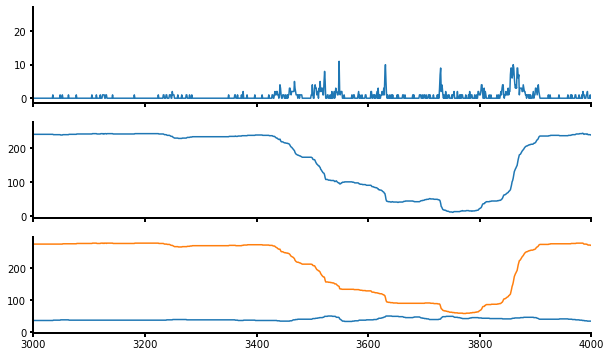

In [63]:
print(the_com.shape)
print(np.diff(the_com).shape)
f,ax = plt.subplots(3,1,figsize=(10,6), sharex=True)
ax[0].plot(abs(np.diff(the_com[:,0])) + abs(np.diff(the_com[:,1])))
ax[1].plot(abs(np.diff(the_com)))
ax[2].plot(the_com[:,0])
ax[2].plot(the_com[:,1])

ax[0].set_xlim(3000,4000)

for a in ax:
    twoaxis(a)
plt.show()

In [177]:
## distance traveled for each task section:
epoch_times = [0, int(5*60*20), int(15*60*20)]
buffer_len = 30*20

locomotion_dict = dict()


for subj in np.unique(subj_ids):
    print(subj)
    com_fn = behavior_dir + vid_df.behav_data_basename.loc[vid_df.subject_ID==subj].values[0]+'_COM.csv'
    #print(com_fn)
    the_com = np.loadtxt(com_fn, delimiter=',')
    
    the_epochs = list(np.copy(epoch_times))
    the_epochs.append(len(the_com))
    epoch_segs = [[i+buffer_len, j-buffer_len] for i,j in zip(the_epochs[0:-1], the_epochs[1:])]
    
    locomotion_list = []
    for seg_i, seg in enumerate(epoch_segs):
        #print(seg)
        #left_time = int(sum(the_com[seg[0]:seg[1], 1] < x_threshs[0]))
        #right_time = int(sum(the_com[seg[0]:seg[1], 1] > x_threshs[1]))
        pixels_traveled = sum(abs(np.diff(the_com[seg[0]:seg[1],0])) + abs(np.diff(the_com[seg[0]:seg[1],1])) ) 
        locomotion_list.append(pixels_traveled)
        #print(locomotion_list)
        
    locomotion_dict[subj] = locomotion_list
    print('\n')
    
print(locomotion_dict)

OM035


OM038


OM040


OM042


OM045


OM047


OM051


{'OM035': [1802.0, 4338.0, 4759.0], 'OM038': [4535.0, 9995.0, 8107.0], 'OM040': [1940.0, 3683.0, 3565.0], 'OM042': [2878.0, 5080.0, 4403.0], 'OM045': [5515.0, 10359.0, 11397.0], 'OM047': [2659.0, 5617.0, 5540.0], 'OM051': [2418.0, 3377.0, 3651.0]}


In [178]:
vid_df

,subject_ID,genotype,data_dir_behavior,behav_data_basename,novel_side
12,OM047,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-11-37-35_video,l
13,OM045,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-12-15-55_video,r
14,OM038,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-13-22-44_video,l
15,OM051,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-14-02-40_video,r
16,OM042,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-14-41-15_video,l
17,OM040,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-15-21-57_video,r
18,OM035,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-16-29-32_video,l


In [179]:
vid_df['distance_traveled'] = vid_df['subject_ID'].map(locomotion_dict)

In [180]:
vid_df

,subject_ID,genotype,data_dir_behavior,behav_data_basename,novel_side,distance_traveled
12,OM047,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-11-37-35_video,l,"[2659.0, 5617.0, 5540.0]"
13,OM045,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-12-15-55_video,r,"[5515.0, 10359.0, 11397.0]"
14,OM038,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-13-22-44_video,l,"[4535.0, 9995.0, 8107.0]"
15,OM051,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-14-02-40_video,r,"[2418.0, 3377.0, 3651.0]"
16,OM042,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-14-41-15_video,l,"[2878.0, 5080.0, 4403.0]"
17,OM040,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-15-21-57_video,r,"[1940.0, 3683.0, 3565.0]"
18,OM035,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-16-29-32_video,l,"[1802.0, 4338.0, 4759.0]"


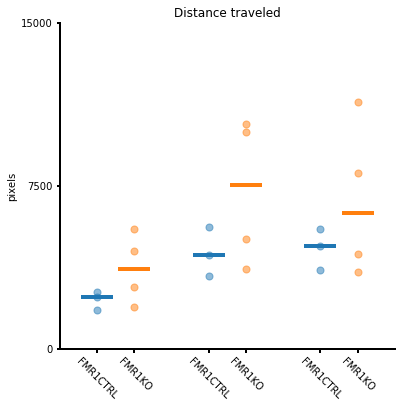

In [181]:
f,ax = plt.subplots(1, 1, figsize = (6,6))

cmap = plt.get_cmap('tab10')
cdict = dict(zip(vid_df.genotype.unique(), [cmap(i) for i in np.arange(len(vid_df.genotype.unique()))]))
tick_list = []

for i in range(3):
    for gi, gtype in enumerate(vid_df.genotype.unique()):
        stat_vect = [stat[i] for stat in vid_df.distance_traveled.loc[vid_df.genotype == gtype]]
        ax.scatter(np.zeros_like(stat_vect) + (i*3) + gi , stat_vect, s=50, color=cdict[gtype], alpha=.5)
        ax.scatter( (i*3) + gi, np.median(stat_vect), s=1000, marker='_', color = cdict[gtype], linewidth = 4)
        tick_list.append((i*3) + gi)

ax.set_xticks(tick_list)
ax.set_xticklabels(['FMR1CTRL', 'FMR1KO'] * 3, rotation=315)
ax.set_ylim(0,15000)
ax.set_yticks([0,7500,15000])
ax.set_xlim(-1,8)
ax.set_title('Distance traveled')
#ax.grid('on', alpha=.5)
ax.set_ylabel('pixels')

twoaxis(ax)
plt.show()

### Social area restricted analysis

In [182]:
print(subj_ids)
epoch_times = [0, int(5*60*20), int(15*60*20)]
buffer_len = 30*20


['OM047' 'OM045' 'OM038' 'OM051' 'OM042' 'OM040' 'OM035']


In [183]:
subj = subj_ids[0]
com_fn = behavior_dir + vid_df.behav_data_basename.loc[vid_df.subject_ID==subj].values[0]+'_COM.csv'

the_com = np.loadtxt(com_fn, delimiter=',')

the_epochs = list(np.copy(epoch_times))
the_epochs.append(len(the_com))
epoch_segs = [[i+buffer_len, j-buffer_len] for i,j in zip(the_epochs[0:-1], the_epochs[1:])]

In [184]:
print(epoch_segs)

[[600, 5400], [6600, 17400], [18600, 31003]]


In [228]:
print(max(the_com[:,0]))
print(max(the_com[:,1]))

55.0
285.0


In [236]:
left_frames = np.argwhere(the_com[:,1] < x_threshs[0]).flatten()
right_frames = np.argwhere(the_com[:,1] > x_threshs[1]).flatten()

In [237]:
print(left_frames)

[ 2042  2043  2044 ... 30237 30238 30239]


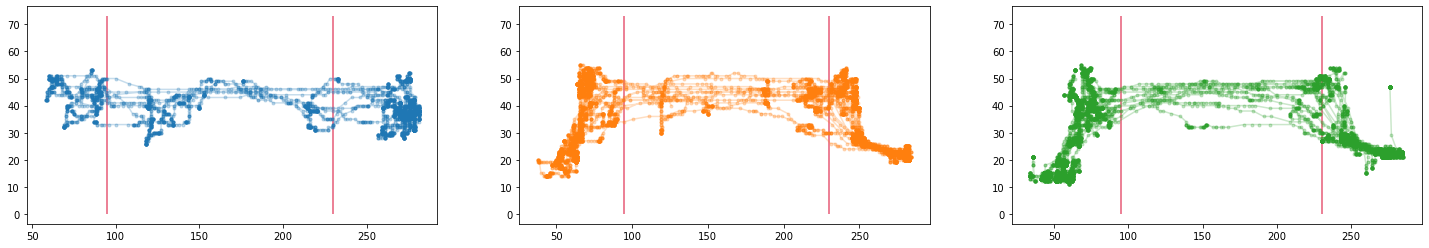

In [225]:
f,ax = plt.subplots(1,3,figsize=(25,4))

ax[0].plot(the_com[epoch_segs[0][0]:epoch_segs[0][1],1], the_com[epoch_segs[0][0]:epoch_segs[0][1],0], '-o', markersize=3, color=cmap(0), alpha=.25)

ax[1].plot(the_com[epoch_segs[1][0]:epoch_segs[1][1],1], the_com[epoch_segs[1][0]:epoch_segs[1][1],0], '-o', markersize=3, color=cmap(1), alpha=.25)

ax[2].plot(the_com[epoch_segs[2][0]:epoch_segs[2][1],1], the_com[epoch_segs[2][0]:epoch_segs[2][1],0], '-o', markersize=3, color=cmap(2), alpha=.25)

for a in ax:
    a.vlines(x_threshs, ymin=0, ymax=frame_height-1, color='crimson', alpha=.7)

plt.show()

31603
